In [1]:
import numpy as np
import pandas as pd

In [2]:
# @title 데이터취득
# https://drive.google.com/file/d/1iS1F7R1waTTOmL7Ab9i2ULQTqj8tIhee/view?usp=sharing
# https://drive.google.com/file/d/18NhRknuccAG4ENMqgZjENhMs6YzpCcvf/view?usp=sharing resized
import gdown, os, zipfile

file_id = '18NhRknuccAG4ENMqgZjENhMs6YzpCcvf'
output = 'data.zip'

gdown.download(f'http://drive.google.com/uc?id={file_id}', output, quiet=False)

output_dir = 'furniture'
os.makedirs(output_dir, exist_ok=True)  # 폴더가 없으면 생성

with zipfile.ZipFile(output, 'r') as z:
    z.extractall(output_dir)  # output_dir에 압축 해제
    print(f"압축 해제 완료: {output_dir}")

# 압축 해제된 폴더 내용 확인
print("압축 해제된 파일 및 폴더 목록:")
print(os.listdir(output_dir))


Downloading...
From: http://drive.google.com/uc?id=18NhRknuccAG4ENMqgZjENhMs6YzpCcvf
To: /content/data.zip
100%|██████████| 25.7M/25.7M [00:00<00:00, 43.0MB/s]

압축 해제 완료: furniture
압축 해제된 파일 및 폴더 목록:
['resized_data_40']


In [3]:
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder

def load_data(base_dir='/content/furniture/resized_data_40'):
    images = []
    labels = []
    class_names = []

    # 최상위 디렉토리의 클래스 이름 가져오기
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):  # 클래스 디렉토리인지 확인
            class_names.append(class_name)  # 클래스 이름 추가

            # 클래스 내부의 모든 이미지 탐색
            for root, _, files in os.walk(class_path):
                for file_name in files:
                    if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):  # 이미지 파일만
                        image_path = os.path.join(root, file_name)
                        images.append(image_path)
                        labels.append(class_name)

    return np.array(images), np.array(labels), class_names

# 데이터 로드
images, labels, class_names = load_data()

# 라벨 인코딩 및 원핫인코딩
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# 출력
print(f"Number of Classes: {len(class_names)}")
print(f"Class Names: {class_names}")
print(f"Number of Images: {len(images)}")
print(f"Sample Images: {images[:5]}")
print(f"Sample Labels: {labels[:5]}")
# print(f"Sample Labels: {encoded_labels[:5]}")


Number of Classes: 4
Class Names: ['chair', 'dining_table', 'sofa', 'cabinet']
Number of Images: 804
Sample Images: ['/content/furniture/resized_data_40/chair/resized_29.jpg'
 '/content/furniture/resized_data_40/chair/resized_78.jpg'
 '/content/furniture/resized_data_40/chair/resized_60.jpg'
 '/content/furniture/resized_data_40/chair/resized_167.jpg'
 '/content/furniture/resized_data_40/chair/resized_105.jpg']
Sample Labels: [1 1 1 1 1]


In [4]:
# @title Sequence 객체 만들기
from tensorflow.keras.utils import Sequence
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

class FurnitureSequence(Sequence):
  def __init__(self, images, labels, batch_size=32, image_size=224, augmentor=None, preprocess_function=None, shuffle=True):
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    self.image_size = image_size
    self.augmentor = augmentor
    self.preprocess_function = preprocess_function
    self.shuffle = shuffle
    self.indexes = np.arange(len(images))
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __len__(self):
    return int(np.ceil(len(self.images) / self.batch_size)) # 배치 사이즈만큼 돌리기

  def __getitem__(self, index): #index번재 배치 데이터 반환
    start = index * self.batch_size
    end = (index + 1) * self.batch_size
    this_batch_images = self.images[start:end]
    batch_labels = self.labels[start:end] if self.labels is not None else None # 예측에는 라벨 필요없음

    # 배치 크기에 맞는 배열 초기화 (리사이즈된 결과를 저장할 새로운 배열 필요)
    batch_images = np.zeros((this_batch_images.shape[0], self.image_size, self.image_size, 3), dtype=np.float32)

    for i, image_path in enumerate(this_batch_images):
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # 데이터 증강 적용
      if self.augmentor is not None:
        image = self.augmentor(image)['image'] # augment 딕셔너리 반환해서, 필요한 데이터(이미지만 추출)만 명시적으로 추출, 데이터 증강 도구는 이미지 외의 데이터를 함께 처리할 수 있어서('mask','bboxes' 등)

      # 리사이즈
      image = cv2.resize(image,(self.image_size, self.image_size))

      # 정규화
      image = image.astype('float32')/255.0

      # 전처리
      if self.preprocess_function is not None:
        image = self.preprocess_function(image)

      batch_images[i] = image

    return (batch_images, batch_labels) if self.labels is not None else batch_images

  def on_epoch_end(self): # 에포크 종료 후 데이터 섞기.
    if self.shuffle:
      self.images, self.labels = shuffle(self.images, self.labels)



In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.utils import to_categorical

# 데이터 분할
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.3, random_state=42)
tr_images, val_images, tr_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Sequence 객체 생성
train_seq = FurnitureSequence(tr_images, tr_labels, batch_size=32, image_size=224, preprocess_function=preprocess_input, shuffle=True)
val_seq = FurnitureSequence(val_images, val_labels, batch_size=32, image_size=224, preprocess_function=preprocess_input, shuffle=False)
test_seq = FurnitureSequence(test_images, test_labels, batch_size=32, image_size=224, preprocess_function=preprocess_input, shuffle=False)

tr_batch_images, tr_batch_labels = next(iter(train_seq)) # seq객체 next로 보고싶으면 iter객체로 감싸서 볼 수 있고, 배치 이미지를 반환함
tr_batch_images.shape, tr_batch_labels.shape

((32, 224, 224, 3), (32,))

In [14]:
# @ title 모델 생성
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,BatchNormalization
from tensorflow.keras.models import Model

# EfficientNetB0 모델 로드 (ImageNet 가중치 사용)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 출력층 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(1024, activation='relu')(x)  # Fully Connected Layer
x = Dropout(0.5)(x)  # Dropout으로 과적합 방지
x = Dense(512, activation='relu')(x)  # Fully Connected Layer
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)  # 최종 출력층 (4개 클래스)

# 최종 모델 정의
model = Model(inputs=base_model.input, outputs=output)
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 5,890,215 (22.47 MB)

 Trainable params: 5,847,168 (22.31 MB)

 Non-trainable params: 43,047 (168.16 KB)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step - accuracy: 0.2548 - loss: 2.4808 - val_accuracy: 0.2035 - val_loss: 1.3877 - learning_rate: 1.0000e-05
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.2659 - loss: 2.4301 - val_accuracy: 0.2035 - val_loss: 1.3911 - learning_rate: 1.0000e-05
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.2678 - loss: 2.2387 - val_accuracy: 0.2035 - val_loss: 1.3945 - learning_rate: 1.0000e-05
Epoch 4/30
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.3210 - loss: 2.0414
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.3232 - loss: 2.0456 - val_accuracy: 0.2035 - val_loss: 1.3972 - learning_rate: 1.0000e-05
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.3104 - loss: 2.2046 - val_accuracy: 0.2035 - val_loss: 1.4042 - learning_rate: 2.0000e-06
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.274

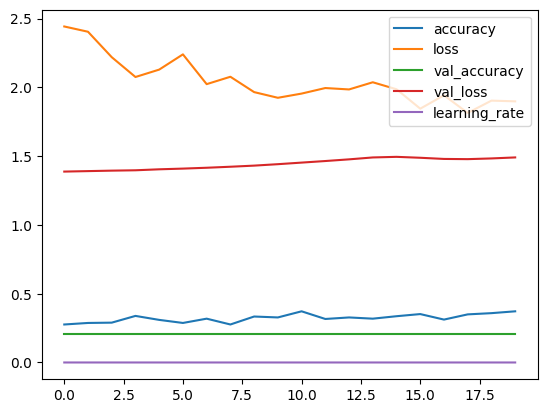

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 680ms/step - accuracy: 0.2644 - loss: 1.4505
Test Accuracy: 27.69%


In [15]:
# @title 모델 컴파일/학습 & 미세조정

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 특성추출층 freeze
for layer in model.layers[:5]:
  layer.trainable = False

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 콜백 설정
early_stop = EarlyStopping(patience=5, mode='max', restore_best_weights=True,verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# 모델 학습
history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=30,
    callbacks=[early_stop,reduce_lr],
    verbose=1)

#시각화
pd.DataFrame(history.history).plot()
plt.show()

# 평가
loss, acc = model.evaluate(test_seq)
loss, acc
print(f"Test Accuracy: {acc * 100:.2f}%")

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.2753 - loss: 2.0738 - val_accuracy: 0.2035 - val_loss: 1.4831 - learning_rate: 1.0000e-05
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.3956 - loss: 1.7995 - val_accuracy: 0.2035 - val_loss: 1.4780 - learning_rate: 1.0000e-05
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.3662 - loss: 1.9184 - val_accuracy: 0.2035 - val_loss: 1.4663 - learning_rate: 1.0000e-05
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.4365 - loss: 1.7282 - val_accuracy: 0.2035 - val_loss: 1.4634 - learning_rate: 1.0000e-05
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.4338 - loss: 1.6960 - val_accuracy: 0.2035 - val_loss: 1.4765 - learning_rate: 1.0000e-05
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.3808 - loss: 1.8079 - val_accuracy: 0.2035 - val_loss: 1.4836 - learning_rate: 1.0000e-05
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0

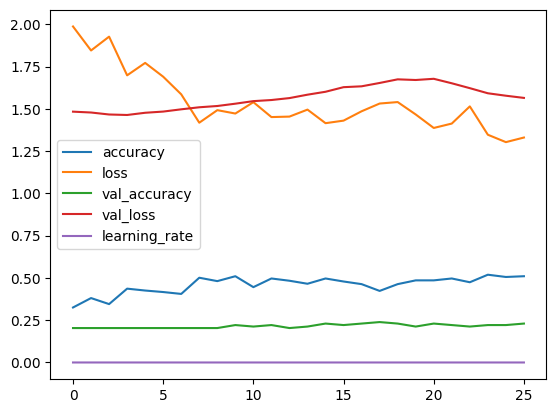

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 579ms/step - accuracy: 0.2648 - loss: 1.5406
Test Accuracy: 28.10%


In [16]:
# @title 미세조정

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# 특성추출층 unfreeze
for layer in model.layers:
  if not isinstance(layer, layers.BatchNormalization):
    layer.trainable = True

model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(learning_rate=0.00001),metrics=['accuracy'])

# 콜백 설정
early_stop = EarlyStopping(patience=5, mode='max', restore_best_weights=True,verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# 모델 학습
history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=30,
    callbacks=[early_stop,reduce_lr],
    verbose=1)

#시각화
pd.DataFrame(history.history).plot()
plt.show()

# 평가
loss, acc = model.evaluate(test_seq)
loss, acc
print(f"Test Accuracy: {acc * 100:.2f}%")

In [ ]:
# @title 테스트 이미지 예측

# pred_proba = model.predict()